# Showcase of clear sky detection and fit
Here the clear sky detection mask and fitted global irradiance can be showed to compare the behavior of the utilization of different CSM. First select a DWD station and one or more dates, see below

In [1]:
import os
import datetime as dt
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import configparser


import modules.load_data as ld


# paths
config = configparser.ConfigParser()
config.read("ConfigFile.ini")
PF = config['PATHS']['datasets']

PF_DWD = os.path.join(PF,"DWD/2015_{station}.nc")
PF_CSD = os.path.join(PF,"CSD/BS_{station}.nc")
PF_CSF = os.path.join(PF,"CSF/{model}_{station}.nc")

MODELS = ['MRM61', #aod550
          'MMAC', # aod0
          'Heliosat1I',#aod550
          'CEM', # aod0
          'ESRA',# aod550
          'METSTAT',# aod0
          'SOLISsimple'] # aod700

STATIONS = ld.dwd_stations()


print("DWD Stations:")
print(STATIONS.station.values)

DWD Stations:
['AK' 'BG' 'BN' 'CH' 'DN' 'FB' 'FL' 'GZ' 'HF' 'HP' 'KS' 'LG' 'LZ' 'NB'
 'NY' 'PG' 'PT' 'RO' 'SG' 'SN' 'SR' 'SY' 'TR' 'WN' 'WZ' 'ZG']


### Choose station:

In [2]:
## config
# choose station
STATION = 'FB'

CSF_dates = np.array([],dtype='datetime64')
for model in MODELS:
    CSF = xr.open_dataset(PF_CSF.format(model=model,station=STATION))
    CSF_dates = np.concatenate((CSF_dates,np.unique(CSF.time.values.astype('datetime64[D]'))),axis=0)
CSF_dates = np.unique(CSF_dates)

print("CSF is available at this dates:")
print(CSF_dates)

CSF is available at this dates:
['2015-02-13' '2015-03-19' '2015-03-20' '2015-03-21' '2015-04-21'
 '2015-06-05' '2015-06-06' '2015-06-16' '2015-07-02' '2015-07-11'
 '2015-08-23' '2015-08-26' '2015-09-28' '2015-10-02' '2015-10-12'
 '2015-11-01' '2015-11-02' '2015-11-03']


### Choose dates (dont have to have available CSF):

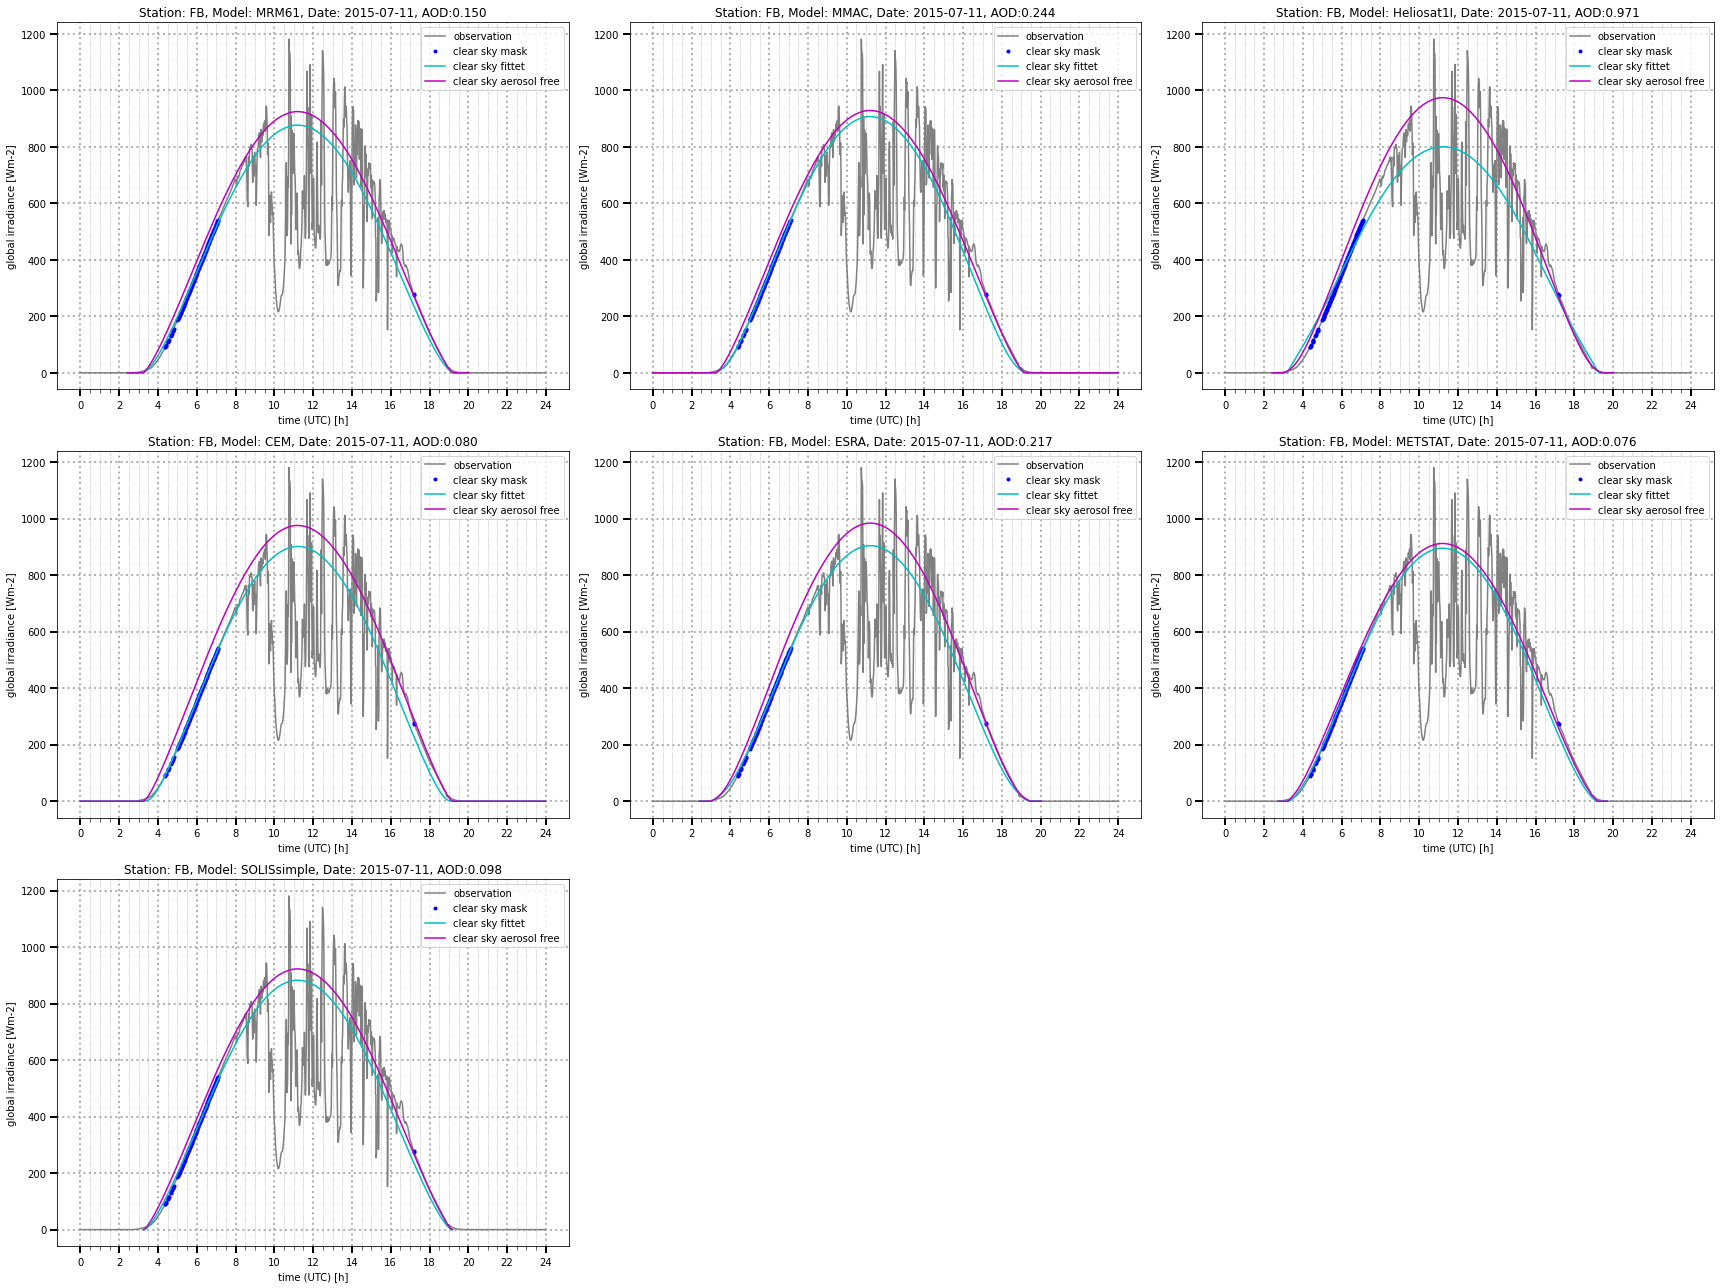

In [3]:
DATES = [
    dt.date(2015,7,11)
]

DWD = xr.open_dataset(PF_DWD.format(station=STATION))
CSD = xr.open_dataset(PF_CSD.format(station=STATION))

i=0
N=len(DATES)*len(MODELS)

fig = plt.figure(figsize=(8*min([3,N]),
                          6*int(np.ceil(N/3))))
for MODEL in MODELS:
    CSF = xr.open_dataset(PF_CSF.format(station=STATION,
                                        model=MODEL))
    for day in DATES:
        # select data
        dwd = DWD.sel(time = day.strftime('%Y-%m-%d'))
        csd = CSD.sel(time = day.strftime('%Y-%m-%d'))
        csf = CSF.sel(time = day.strftime('%Y-%m-%d'))
        csf = csf.reindex_like(dwd)
        
        idx = csd.csdc.values

        aod=np.mean(csf.aod0.values)
        mghi0 = csf.mghi0.values
        mghi = csf.mghi.values

        # plot the results
        time = dwd.time.dt.hour + dwd.time.dt.minute/60.
        ax = fig.add_subplot(int(np.ceil(N/3)),min([3,N]),i+1)
        ax.set_title(f"Station: {STATION}, Model: {MODEL}, Date: {day:%Y-%m-%d}, AOD:{aod:.3f}")
        ax.plot(time, dwd['global'], color=(0.5,0.5,0.5), label='observation')
        ax.plot(time[idx],dwd['global'][idx],'b.',label='clear sky mask')
        ax.plot(time,mghi,'c',label='clear sky fittet')
        ax.plot(time,mghi0,'m',label='clear sky aerosol free')


        ax.set_ylabel("global irradiance [Wm-2]")
        ax.set_xlabel("time (UTC) [h]")
        ax.set_xticks(np.arange(0,26,2),minor=False)
        ax.set_xticks(np.arange(0,24.5,0.5),minor=True)
        ax.tick_params(which='major', width=2, length=7)
        ax.tick_params(which='minor', length=4)
        ax.grid(which='major',linestyle=':', linewidth=2)
        ax.grid(which='minor',linestyle=':')
        ax.legend()
        i+=1
plt.tight_layout()